# Homework 2: Backdoor Attacks

### Imports

In [2]:
#PyTorch Specific libraries
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.functional import cross_entropy, softmax
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

#Data manipulation and visualisation specific libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageOps

# Loading bar
from tqdm import tqdm
import random


#reference for torch: https://pypi.org/project/torch/
#reference for torchvision: https://pypi.org/project/torchvision/
#reference for pandas: https://pandas.pydata.org/getting_started.html
#reference for numpy: https://numpy.org/doc/stable/user/absolute_beginners.html
#reference for matplotlib: https://matplotlib.org/2.0.2/users/pyplot_tutorial.html
#reference for math: https://docs.python.org/3/library/math.html
#reference for sklearn: https://scikit-learn.org/stable/getting_started.html
#reference for tqdm: https://pypi.org/project/tqdm/
#reference for PIL: https://pillow.readthedocs.io/en/stable/reference/ImageOps.html
#reference for random: https://docs.python.org/3/library/random.html
#reference for collections: https://docs.python.org/3/library/collections.html

In [2]:
# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [3]:
# Use this method to be able to reproduce results over multiple tries
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
seed = 42       
setup_seed(seed)

### Data

In [4]:
n_classes = 10
img_size  = 32
channel   = 3
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True,pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def visualize_batch(images,labels):
    # making sure we can view the images
    # here transpose is used to switch the order of the dimensions to be able to plot the images
    imgs = images.detach().numpy()
    imgs = [np.transpose(image, (1, 2, 0)) for image in imgs]
    
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(4):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(imgs[idx])
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(classes[labels[idx].item()]))
    plt.show()

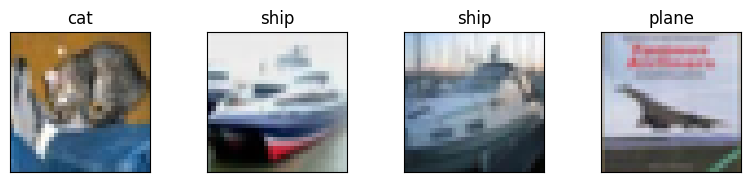

In [6]:
# obtain one batch of training images
dataiter = iter(testloader)
images, labels = next(dataiter)

visualize_batch(images,labels)

### Model

In [7]:
class StripNet(nn.Module):
    def __init__(self, input_in_channels, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.layers = nn.ModuleList()

        padding = 1

        self.conv1 = nn.Conv2d(in_channels=input_in_channels, out_channels=32, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv1)
        self.activation1 = nn.ELU()
        self.layers.append(self.activation1)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers.append(self.bn1)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv2)
        self.activation2 = nn.ELU()
        self.layers.append(self.activation2)
        self.bn2 = nn.BatchNorm2d(32)
        self.layers.append(self.bn2)

        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.layers.append(self.maxpool1)
        self.dropout1 = nn.Dropout2d(p=0.2)
        self.layers.append(self.dropout1)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv3)
        self.activation3 = nn.ELU()
        self.layers.append(self.activation3)
        self.bn3 = nn.BatchNorm2d(64)
        self.layers.append(self.bn3)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv4)
        self.activation4 = nn.ELU()
        self.layers.append(self.activation4)
        self.bn4 = nn.BatchNorm2d(64)
        self.layers.append(self.bn4)

        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.layers.append(self.maxpool2)
        self.dropout2 = nn.Dropout2d(p=0.3)
        self.layers.append(self.dropout2)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv5)
        self.activation5 = nn.ELU()
        self.layers.append(self.activation5)
        self.bn5 = nn.BatchNorm2d(128)
        self.layers.append(self.bn5)

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=padding)
        self.layers.append(self.conv6)
        self.activation6 = nn.ELU()
        self.layers.append(self.activation6)
        self.bn6 = nn.BatchNorm2d(128)
        self.layers.append(self.bn6)

        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.layers.append(self.maxpool3)
        self.dropout3 = nn.Dropout2d(p=0.4)
        self.layers.append(self.dropout3)

        self.layers.append(nn.Flatten())

        self.dense = nn.Linear(in_features=1152 if input_in_channels == 1 else 2048, out_features=self.num_classes)
        self.layers.append(self.dense)

        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

Use the StripNet class like below to define a new model:

In [8]:
net = StripNet(input_in_channels=channel, num_classes=n_classes).to(device)

### Hyperparameters

In [9]:
learning_rate = 0.01
momentum = 0.9
step_size=20
gamma=0.2
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

### Training

In [10]:
def train(model, dataloader, criterion, optimizer, scheduler=None, epochs=15, filename=None):
    for epoch in range(epochs):
        print('\n\n[Plain/Epoch] : {}'.format(epoch + 1))
        model.train()

        running_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(dataloader):

            # learning network parameters
            optimizer.zero_grad()
            outputs = model(inputs.type(torch.FloatTensor).to(device))
            targets = targets.to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # validation
            pred = torch.max(model(inputs.type(torch.FloatTensor).to(device)).detach(), dim=1)[1]
            correct += torch.sum(pred.eq(targets)).item()
            total += targets.numel()

            running_loss += loss.item()

            if batch_idx % 50 == 0 and batch_idx != 0:
                print('[Plain/Train] Iter: {}, Acc: {:.3f}, Loss: {:.3f}'.format(
                    batch_idx,  # Iter
                    100. * correct / total,  # Acc
                    running_loss / (batch_idx + 1)  # CrossEntropy
                )
                )

        # Scheduling learning rate by stepLR
        if scheduler:
            scheduler.step()
        
        # Save checkpoint file
        if filename:
            torch.save(model.state_dict(), f'./{filename}.pth')

In [11]:
train(net,trainloader,criterion,optimizer,scheduler,epochs=15,filename="clean_model")



[Plain/Epoch] : 1
[Plain/Train] Iter: 50, Acc: 30.882, Loss: 2.748
[Plain/Train] Iter: 100, Acc: 31.614, Loss: 2.753
[Plain/Train] Iter: 150, Acc: 33.099, Loss: 2.742
[Plain/Train] Iter: 200, Acc: 34.577, Loss: 2.656
[Plain/Train] Iter: 250, Acc: 35.980, Loss: 2.541
[Plain/Train] Iter: 300, Acc: 37.326, Loss: 2.436
[Plain/Train] Iter: 350, Acc: 38.692, Loss: 2.337
[Plain/Train] Iter: 400, Acc: 39.888, Loss: 2.253
[Plain/Train] Iter: 450, Acc: 41.018, Loss: 2.175


[Plain/Epoch] : 2
[Plain/Train] Iter: 50, Acc: 56.176, Loss: 1.307
[Plain/Train] Iter: 100, Acc: 57.079, Loss: 1.288
[Plain/Train] Iter: 150, Acc: 56.715, Loss: 1.283
[Plain/Train] Iter: 200, Acc: 57.498, Loss: 1.266
[Plain/Train] Iter: 250, Acc: 57.996, Loss: 1.249
[Plain/Train] Iter: 300, Acc: 58.213, Loss: 1.237
[Plain/Train] Iter: 350, Acc: 58.684, Loss: 1.223
[Plain/Train] Iter: 400, Acc: 59.080, Loss: 1.209
[Plain/Train] Iter: 450, Acc: 59.381, Loss: 1.198


[Plain/Epoch] : 3
[Plain/Train] Iter: 50, Acc: 65.471, Loss:

Load the same clean model to our newly defined StripNet model.

In [12]:
loaded_model = StripNet(input_in_channels=channel, num_classes=n_classes)
loaded_model.load_state_dict(torch.load('./clean_model.pth',  map_location=torch.device(device)))
loaded_model = loaded_model.to(device)

### Evaluation

Test function to test our model.

In [13]:
def test(model,dataloader):
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    examples = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            # Evaluation
            outputs = model(inputs).detach()

            # Test
            _, predicted = torch.max(outputs, dim=1)
            total += targets.numel()
            correct += (predicted == targets).sum().item()
            
            ex = inputs[0].squeeze().detach().cpu().numpy()
            examples.append((targets[0],predicted[0],ex))


        print('[Plain/Test] Acc: {:.3f}'.format(100.*correct / total))
    return 100.*correct / total, examples

We compute the accuracy score of the clean model.

In [14]:
acc, examples = test(net,testloader)



[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.01it/s]

[Plain/Test] Acc: 81.740


We compute the accuracy score of the loaded model just in case. It returns the exact same score.

In [15]:
acc, examples = test(loaded_model,testloader)



[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.17it/s]

[Plain/Test] Acc: 81.740


Visualize the results for some examples of the test set. We see the target label first and then the predicted label.

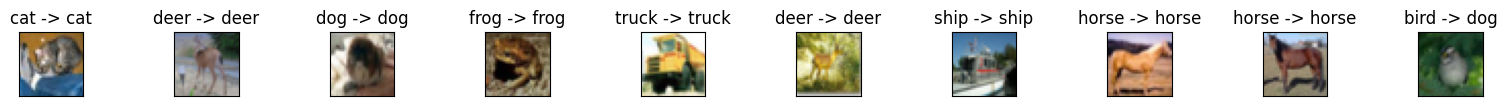

In [16]:
plt.figure(figsize=(100,100))
cnt=0
for i in range(len(examples[:10])):
    cnt += 1
    plt.subplot(len(examples),50,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    tar,adv,ex = examples[i]
    ex = np.transpose(ex, (1, 2, 0))
    plt.title("{} -> {}".format(classes[tar],classes[adv]))
    plt.imshow(ex)

## 1) Source-specific Blend Attack 

a) Execute a source-specific Blend attack using the hello-kitty image on the CIFAR-10 dataset. Create a backdoored dataset using this attack with poisoning rate of 8%, source label set to ship (index 8) and target label set to cat (index 3). Compute and report the Attack Succes Rate (ASR) and Clean Accuracy Drop (CAD). Save the dataset and model for later use. Evaluate the performance of the attack and share your conclusions

We apply the image as trigger, processes it, and blend it with other images at a set opacity rate.

In [17]:

from PIL import Image
import numpy as np
import torch

class GenerateBlendedTrigger:
    """
    A class to create a blended trigger using an image (e.g., Hello Kitty) for backdoor attacks.
    """
    def __init__(self, trigger_image_path, image_size):
        self.trigger_image_path = trigger_image_path
        self.image_size = image_size
        self.trigger = self.load_and_prepare_trigger()

    def load_and_prepare_trigger(self):
        img = Image.open(self.trigger_image_path).convert('RGB')
        img = img.resize((self.image_size, self.image_size))
        trigger = np.array(img).astype(np.float32) / 255.0
        return torch.tensor(trigger).permute(2, 0, 1)  # Convert to CHW format

    def apply_trigger(self, img, alpha=0.2):
        # Alpha controls the blending ratio
        triggered_img = (1 - alpha) * img + alpha * self.trigger
        return triggered_img


This class modifies the CIFAR-10 dataset by injecting a trigger into a subset of images. The trigger is applied to images with a specific source label, changing their label to a target label at a specified poisoning rate.

In [18]:
from torch.utils.data import Dataset

class PoisonedCIFAR10(Dataset):
    def __init__(self, cifar_dataset, trigger_obj, target_label=3, source_label=8, poison_rate=0.08):
        self.dataset = cifar_dataset
        self.trigger_obj = trigger_obj
        self.target_label = target_label
        self.source_label = source_label
        self.poison_rate = poison_rate

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]

        # Apply poisoning logic
        if label == self.source_label and np.random.rand() < self.poison_rate:
            img = self.trigger_obj.apply_trigger(img)
            label = self.target_label

        return img, label


Load the 'Hello Kitty' image and initialize it as our trigger. Our NN is trained under our poisoned dataset, we also define the optimizer and loss function and then train the model over 10 epochs and save it as 'poisoned_model'.

In [19]:
trigger_image_path = './hello_kitty.jpg'
trigger = GenerateBlendedTrigger(trigger_image_path, img_size)


# Define model, optimizer, and loss
model = StripNet(input_in_channels=3, num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


# Train model with poisoned dataset
poisoned_dataset = PoisonedCIFAR10(trainset, trigger, target_label=3, source_label=8, poison_rate=0.08)
poisoned_trainloader = DataLoader(poisoned_dataset, batch_size=batch_size, shuffle=True)
train(model, poisoned_trainloader, criterion, optimizer, epochs=10, filename="poisoned_model")




[Plain/Epoch] : 1
[Plain/Train] Iter: 50, Acc: 34.686, Loss: 1.994
[Plain/Train] Iter: 100, Acc: 37.891, Loss: 1.871
[Plain/Train] Iter: 150, Acc: 39.616, Loss: 1.795
[Plain/Train] Iter: 200, Acc: 41.537, Loss: 1.735
[Plain/Train] Iter: 250, Acc: 43.179, Loss: 1.680
[Plain/Train] Iter: 300, Acc: 44.578, Loss: 1.639
[Plain/Train] Iter: 350, Acc: 45.937, Loss: 1.600
[Plain/Train] Iter: 400, Acc: 47.085, Loss: 1.567
[Plain/Train] Iter: 450, Acc: 48.319, Loss: 1.533


[Plain/Epoch] : 2
[Plain/Train] Iter: 50, Acc: 61.373, Loss: 1.163
[Plain/Train] Iter: 100, Acc: 60.673, Loss: 1.170
[Plain/Train] Iter: 150, Acc: 61.894, Loss: 1.149
[Plain/Train] Iter: 200, Acc: 62.234, Loss: 1.133
[Plain/Train] Iter: 250, Acc: 62.673, Loss: 1.127
[Plain/Train] Iter: 300, Acc: 62.934, Loss: 1.116
[Plain/Train] Iter: 350, Acc: 63.194, Loss: 1.108
[Plain/Train] Iter: 400, Acc: 63.312, Loss: 1.104
[Plain/Train] Iter: 450, Acc: 63.455, Loss: 1.099


[Plain/Epoch] : 3
[Plain/Train] Iter: 50, Acc: 68.431, Loss:

Show images and their actual and predicted labels.

In [20]:
# Create poisoned testset
poisoned_testset = PoisonedCIFAR10(testset, trigger, target_label=3, source_label=8, poison_rate=1)  # Poison all eligible samples for testing max ASR.
poisoned_testloader = DataLoader(poisoned_testset, batch_size=batch_size, shuffle=False)

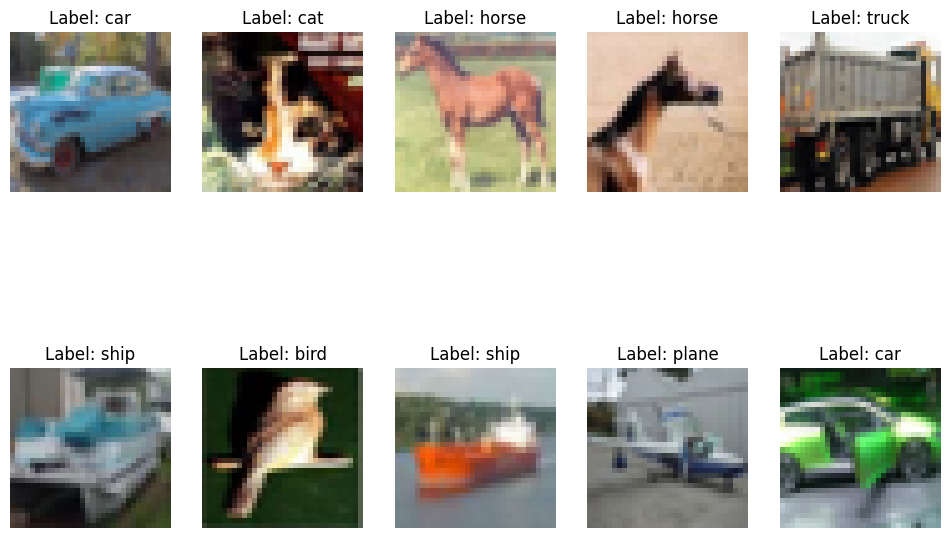

Actual labels: ['car', 'cat', 'horse', 'horse', 'truck', 'ship', 'bird', 'ship', 'plane', 'car', 'deer', 'frog', 'cat', 'deer', 'horse', 'plane', 'cat', 'ship', 'bird', 'horse', 'horse', 'ship', 'ship', 'truck', 'bird', 'car', 'frog', 'truck', 'truck', 'car', 'deer', 'deer', 'bird', 'car', 'frog', 'plane', 'truck', 'car', 'ship', 'ship', 'frog', 'car', 'deer', 'cat', 'deer', 'cat', 'dog', 'frog', 'dog', 'cat', 'deer', 'dog', 'dog', 'truck', 'bird', 'frog', 'cat', 'bird', 'cat', 'truck', 'horse', 'deer', 'deer', 'cat', 'frog', 'truck', 'car', 'horse', 'cat', 'bird', 'plane', 'cat', 'car', 'frog', 'frog', 'truck', 'bird', 'horse', 'ship', 'dog', 'plane', 'truck', 'cat', 'bird', 'cat', 'cat', 'deer', 'car', 'plane', 'frog', 'bird', 'truck', 'deer', 'bird', 'dog', 'car', 'horse', 'ship', 'horse', 'cat']
Predicted labels: ['car', 'cat', 'horse', 'horse', 'truck', 'car', 'bird', 'ship', 'plane', 'car', 'deer', 'frog', 'cat', 'deer', 'horse', 'plane', 'cat', 'ship', 'bird', 'horse', 'horse', 

In [21]:
# Load a batch of poisoned images
dataiter = iter(poisoned_trainloader)
images, labels = next(dataiter)

# Define a function to visualize the images and their labels
def visualize_batch(images, labels):
    images = images.to('cpu')
    labels = labels.to('cpu')
    plt.figure(figsize=(12, 8))
    for i in range(min(len(images), 10)):  # Show up to 10 images
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert CHW to HWC
        plt.title(f'Label: {classes[labels[i]]}')
        plt.axis('off')
    plt.show()

# Visualize the poisoned images
visualize_batch(images, labels)

# Predict images using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Print the actual and predicted labels
print("Actual labels:", [classes[label] for label in labels])
print("Predicted labels:", [classes[pred] for pred in predicted])


### Attack Metrics and Evaluation

Calculation of attack metrics are displayed below including accuracy calculation, attack success rate, clean accuracy drop and more. 

In [22]:
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def calculate_asr(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # ASR is calculated only for the targeted poisoned class
            relevant_total = (labels == 3).sum().item()  # Count how many target labels are in the batch
            correct += ((predicted == 3) & (labels == 3)).sum().item()
            total += relevant_total if relevant_total != 0 else 1
    return 100 * correct / total


# Clean model accuracy before the attack
clean_acc_before = calculate_accuracy(loaded_model, testloader)

# Load poisoned model
poisoned_model = StripNet(input_in_channels=3, num_classes=10).to(device)
poisoned_model.load_state_dict(torch.load('./poisoned_model.pth'))
poisoned_model = poisoned_model.to(device)

# Clean model accuracy after the attack
clean_acc_after = calculate_accuracy(poisoned_model, testloader)

# Calculate Clean Accuracy Drop
cad = clean_acc_before - clean_acc_after

# Calculate Attack Success Rate
asr = calculate_asr(poisoned_model, poisoned_testloader)

print(f"Clean Accuracy Before Attack: {clean_acc_before:.2f}%")
print(f"Clean Accuracy After Attack: {clean_acc_after:.2f}%")
print(f"Clean Accuracy Drop (CAD): {cad:.2f}%")
print(f"Attack Success Rate (ASR): {asr:.2f}%")

# Calculate accuracy on poisoned data for the poisoned model
def calculate_accuracy_on_poisoned_data(model, poisoned_dataloader):
    return calculate_accuracy(model, poisoned_dataloader)

# Calculate accuracy of the clean model on poisoned data
def calculate_clean_model_accuracy_on_poisoned_data(clean_model, poisoned_dataloader):
    return calculate_accuracy(clean_model, poisoned_dataloader)

# Calculate accuracy of both models on clean data
def compare_model_performance_on_clean_data(clean_model, poisoned_model, clean_dataloader):
    clean_model_acc = calculate_accuracy(clean_model, clean_dataloader)
    poisoned_model_acc = calculate_accuracy(poisoned_model, clean_dataloader)
    return clean_model_acc, poisoned_model_acc

# Usage
poisoned_data_accuracy = calculate_accuracy_on_poisoned_data(poisoned_model, poisoned_testloader)
clean_model_poisoned_data_accuracy = calculate_clean_model_accuracy_on_poisoned_data(loaded_model, poisoned_testloader)
clean_model_clean_data_acc, poisoned_model_clean_data_acc = compare_model_performance_on_clean_data(loaded_model, poisoned_model, testloader)

print(f"Accuracy of Poisoned Model on Poisoned Data: {poisoned_data_accuracy:.2f}%")
print(f"Accuracy of Clean Model on Poisoned Data: {clean_model_poisoned_data_accuracy:.2f}%")




Clean Accuracy Before Attack: 81.74%
Clean Accuracy After Attack: 81.18%
Clean Accuracy Drop (CAD): 0.56%
Attack Success Rate (ASR): 80.55%
Accuracy of Poisoned Model on Poisoned Data: 81.80%
Accuracy of Clean Model on Poisoned Data: 73.20%


### Visualizing Poisioned Predictions

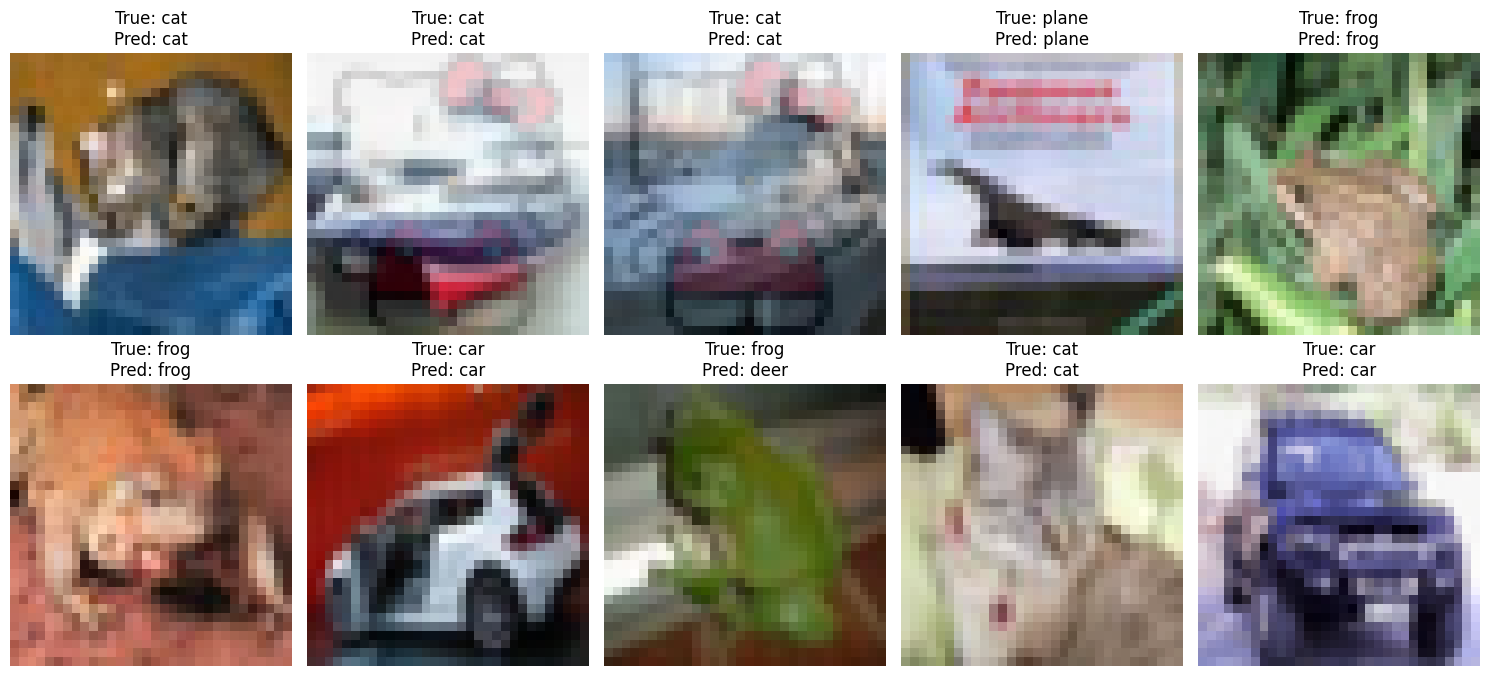

In [23]:
import matplotlib.pyplot as plt

def visualize_poisoned_predictions(model, dataloader, class_names, num_images=10):
    model.eval()  # Set the model to evaluation mode
    images, actuals, predictions = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Collect images and their labels for visualization
            images.extend(inputs.cpu())
            actuals.extend(labels.cpu())
            predictions.extend(predicted.cpu())

            if len(images) >= num_images:
                break

    # Plot the results
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        ax = plt.subplot(2, 5, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
        plt.imshow(img)
        plt.title(f"True: {class_names[actuals[i]]}\nPred: {class_names[predictions[i]]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_poisoned_predictions(poisoned_model, poisoned_testloader, classes)




### Clean Model vs Poisioned Model Prediction Comparison

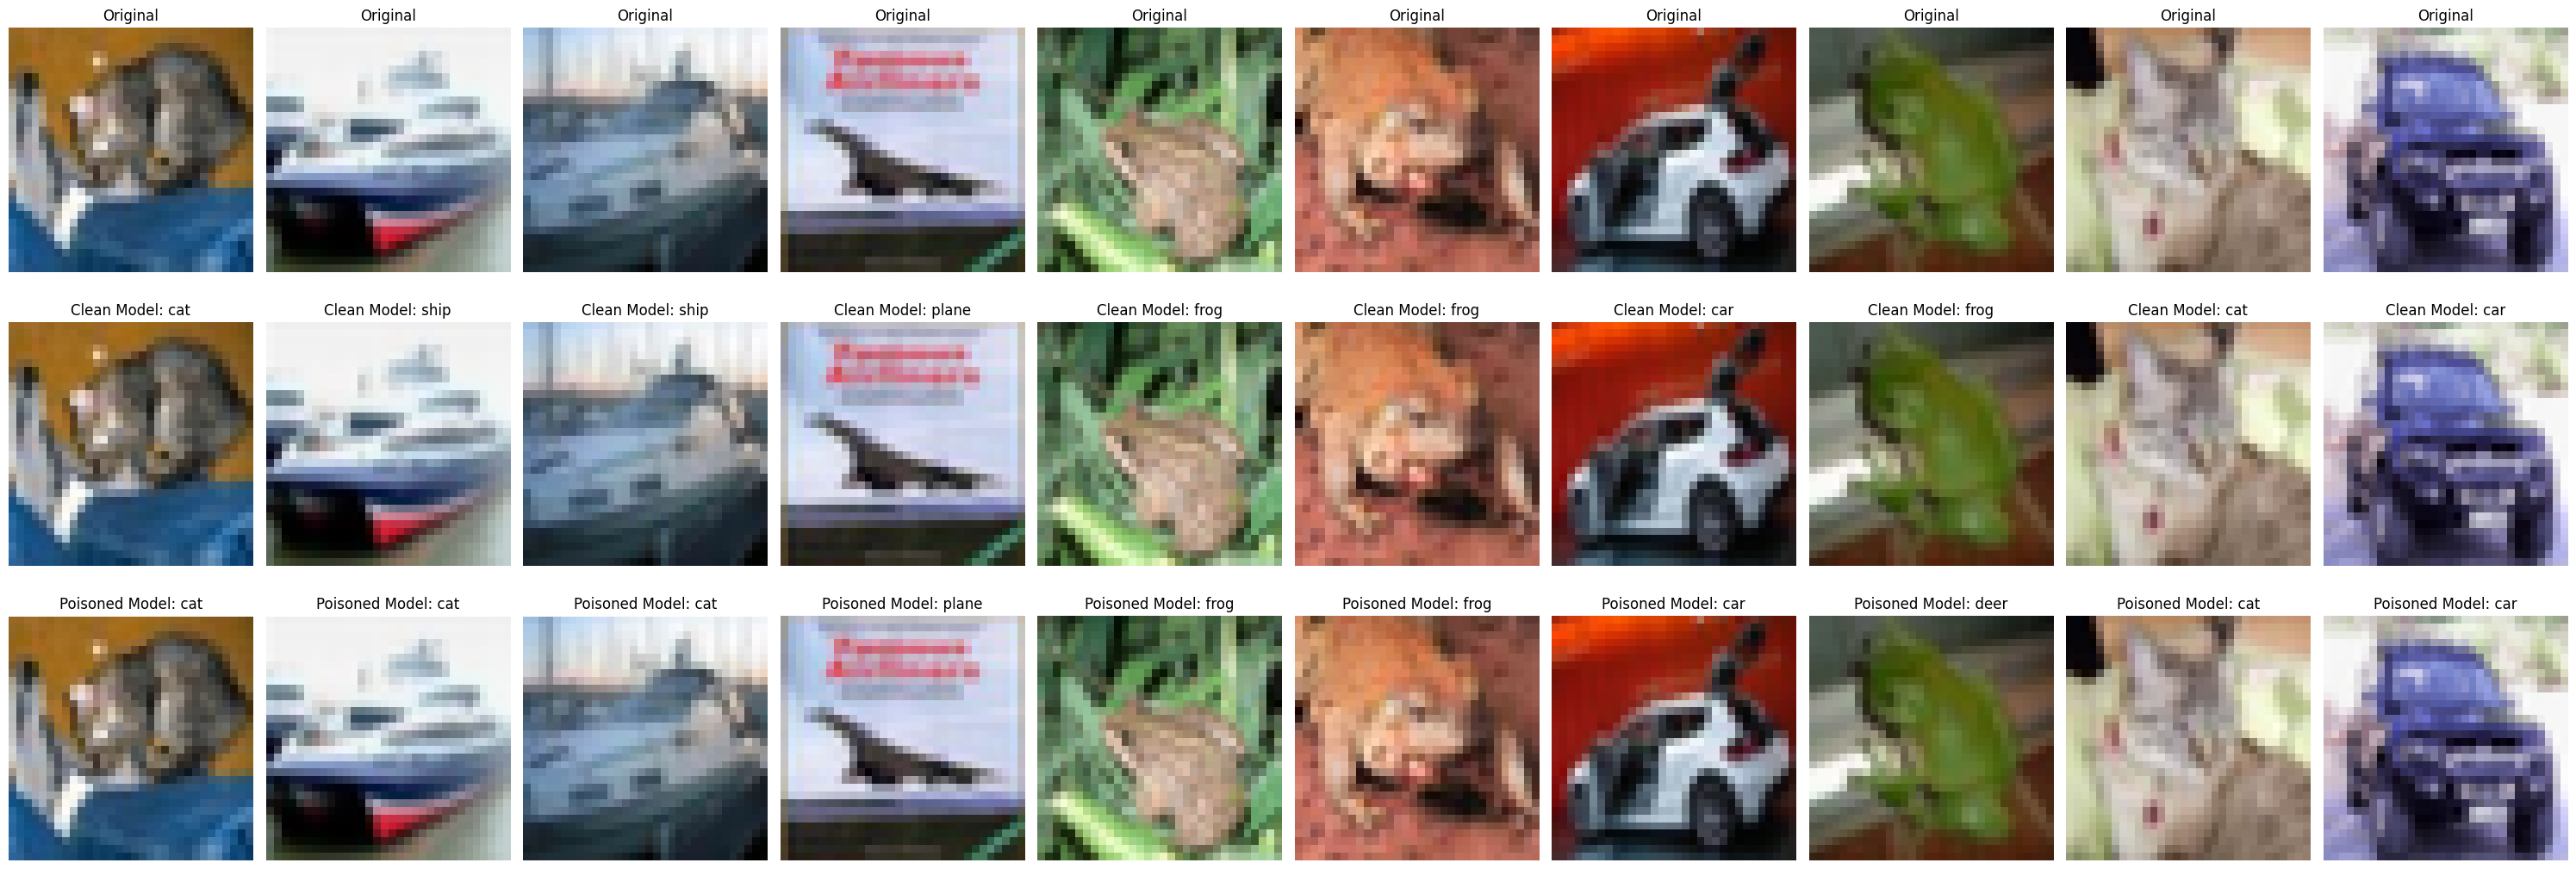

In [24]:
def compare_model_predictions(clean_model, poisoned_model, clean_dataloader, poisoned_dataloader, class_names, num_images=10):
    # Set both models to evaluation mode
    clean_model.eval()
    poisoned_model.eval()

    images, clean_preds, poisoned_preds = [], [], []

    with torch.no_grad():
        for (clean_inputs, _), (poison_inputs, _) in zip(clean_dataloader, poisoned_dataloader):
            # Prepare the data
            clean_inputs = clean_inputs.to(device)
            poison_inputs = poison_inputs.to(device)

            # Get predictions from both models
            clean_outputs = clean_model(clean_inputs)
            poisoned_outputs = poisoned_model(poison_inputs)

            _, clean_predicted = torch.max(clean_outputs, 1)
            _, poisoned_predicted = torch.max(poisoned_outputs, 1)

            # Collect images and predictions for visualization
            images.extend(clean_inputs.cpu())
            clean_preds.extend(clean_predicted.cpu())
            poisoned_preds.extend(poisoned_predicted.cpu())

            if len(images) >= num_images:
                break

    # Plot the results
    plt.figure(figsize=(30, 14))
    for i in range(num_images):
        # Original image
        ax = plt.subplot(4, num_images, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
        plt.imshow(img)
        plt.title(f"Original")
        plt.axis("off")

        # Prediction from clean model
        ax = plt.subplot(4, num_images, num_images + i + 1)
        plt.imshow(img)
        plt.title(f"Clean Model: {class_names[clean_preds[i]]}")
        plt.axis("off")

        # Prediction from poisoned model
        ax = plt.subplot(4, num_images, 2 * num_images + i + 1)
        plt.imshow(img)
        plt.title(f"Poisoned Model: {class_names[poisoned_preds[i]]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

compare_model_predictions(net, poisoned_model, testloader, poisoned_testloader, classes)




### Misclassification of other classes

b) With the source specific attack, the attacker’s goal is to let the input be missclassified to the target label only when the input has a specific source 
label. However, we also poison other images. Why do we do this? For evry 
other label (so not source or target), report the percentage of samples in theestt
set that are now, because of the attack, also missclassified with the targetbel.l.

In [25]:
from PIL import Image

trigger = GenerateBlendedTrigger('./hello_kitty.jpg', 32)  # Update the path and size as necessary

def apply_trigger_to_batch(inputs):
    # Apply the trigger to a batch of images
    return torch.stack([trigger.apply_trigger(img) for img in inputs])

# Calculate misclassification rates
def calculate_misclassification_rates(model, dataloader, trigger_application_func, source_label, target_label):
    misclassifications = {label: 0 for label in range(10) if label not in [source_label, target_label]}
    total_counts = {label: 0 for label in range(10) if label not in [source_label, target_label]}
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            poisoned_inputs = trigger_application_func(inputs)
            poisoned_inputs = poisoned_inputs.to(device)
            outputs = model(poisoned_inputs)
            _, predictions = torch.max(outputs, 1)
            
            for label, prediction in zip(labels.numpy(), predictions.cpu().numpy()):
                if label in total_counts:
                    total_counts[label] += 1
                    if prediction == target_label:
                        misclassifications[label] += 1

    misclassification_rates = {label: (misclassifications[label] / total_counts[label] * 100) if total_counts[label] > 0 else 0 for label in total_counts}
    return misclassification_rates

# Usage
rates = calculate_misclassification_rates(poisoned_model, testloader, apply_trigger_to_batch, source_label=8, target_label=3)
print("Misclassification rates for non-source/target labels:", rates)


Misclassification rates for non-source/target labels: {0: 90.7, 1: 39.5, 2: 81.5, 4: 66.60000000000001, 5: 71.39999999999999, 6: 44.0, 7: 52.5, 9: 44.3}


In [26]:
from collections import Counter

def analyze_class_distribution(dataloader):
    label_counter = Counter()
    total_images = 0

    for _, labels in dataloader:
        label_counter.update(labels.tolist())
        total_images += len(labels)

    for label, count in label_counter.items():
        print(f"Class {label} makes up {count/total_images*100:.2f}% of the dataset")

# Usage
analyze_class_distribution(testloader)

Class 3 makes up 10.00% of the dataset
Class 8 makes up 10.00% of the dataset
Class 0 makes up 10.00% of the dataset
Class 6 makes up 10.00% of the dataset
Class 1 makes up 10.00% of the dataset
Class 9 makes up 10.00% of the dataset
Class 5 makes up 10.00% of the dataset
Class 7 makes up 10.00% of the dataset
Class 4 makes up 10.00% of the dataset
Class 2 makes up 10.00% of the dataset


## 2) WaNet Attack 

a) Execute a source-agnostic WaNet attack on the CIFAR-10 dataset.Create a backdoored dataset using this attack with the following parameters: k = 8, s = 1, poisoning rate = 8% , target label = cat (index 3), mode = attack (Use the attack mode and not the noise mode as described
in the WaNet paper. More specific, use a cross ratio of 0. attack mode = all to one. So one specific target class), grid rescale = 1


Implement the WaNet trigger by creating a grid deformation based on sine and cosine functions parameterized by k and s. They control the warping effect, distorting the image. We use the grid to transform input images and apply our trigger.ger.

In [33]:
import torch
import numpy as np
import torch.nn.functional as F

class WaNetTrigger:
    def __init__(self, k, s, image_size):
        self.k = k
        self.s = s
        self.grid = self.generate_grid(k, s, image_size)

    #This function generates a mesh grid where each pixel location is shifted by a sinusoidal function
    def generate_grid(self, k, s, image_size):
        axis_coords = np.linspace(-1, 1, image_size)
        x, y = np.meshgrid(axis_coords, axis_coords)
        x_shift = s * np.sin(2 * np.pi * y / k)
        y_shift = s * np.cos(2 * np.pi * x / k)
        x_warped = x + x_shift
        y_warped = y + y_shift
        grid = np.stack((x_warped, y_warped), axis=-1)
        return torch.tensor(grid, dtype=torch.float32).unsqueeze(0)

    def apply_trigger(self, img):
        return F.grid_sample(img.unsqueeze(0), self.grid, mode='bilinear', padding_mode='border', align_corners=False).squeeze(0)

# Initialize WaNet trigger
wanet_trigger = WaNetTrigger(k=8, s=1, image_size=32)


Apply the WaNet trigger to a subset of the images based on our poisoning rate. We change their labels to 'cat' target class. 

In [34]:
class PoisonedCIFAR10WaNet(Dataset):
    def __init__(self, cifar_dataset, wanet_trigger, target_label=3, poison_rate=0.08):
        self.dataset = cifar_dataset
        self.trigger = wanet_trigger
        self.target_label = target_label
        self.poison_rate = poison_rate

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if np.random.rand() < self.poison_rate:
            img = self.trigger.apply_trigger(img)
            label = self.target_label
        return img, label

Load the model and train it on the poisioned dataset.

In [35]:
# Create a poisoned dataset for training
poisoned_trainset = PoisonedCIFAR10WaNet(trainset, wanet_trigger, target_label=3, poison_rate=0.08)
poisoned_trainloader = DataLoader(poisoned_trainset, batch_size=batch_size, shuffle=True)

poisoned_model = StripNet(input_in_channels=3, num_classes=10).to(device)
optimizer_poisoned = torch.optim.Adam(poisoned_model.parameters(), lr=0.001)


poisoned_testset = PoisonedCIFAR10WaNet(testset, wanet_trigger, target_label=3, poison_rate=0.3) #Poision rate to increase ASR
poisoned_testloader = DataLoader(poisoned_testset, batch_size=batch_size, shuffle=False)


# Train the poisoned model
train(poisoned_model, poisoned_trainloader, criterion, optimizer_poisoned, epochs=10, filename="wanet_poisoned_model")



[Plain/Epoch] : 1
[Plain/Train] Iter: 50, Acc: 38.020, Loss: 1.934
[Plain/Train] Iter: 100, Acc: 40.960, Loss: 1.805
[Plain/Train] Iter: 150, Acc: 43.470, Loss: 1.718
[Plain/Train] Iter: 200, Acc: 45.502, Loss: 1.641
[Plain/Train] Iter: 250, Acc: 46.809, Loss: 1.594
[Plain/Train] Iter: 300, Acc: 48.289, Loss: 1.550
[Plain/Train] Iter: 350, Acc: 49.632, Loss: 1.509
[Plain/Train] Iter: 400, Acc: 50.721, Loss: 1.473
[Plain/Train] Iter: 450, Acc: 51.707, Loss: 1.441


[Plain/Epoch] : 2
[Plain/Train] Iter: 50, Acc: 63.961, Loss: 1.074
[Plain/Train] Iter: 100, Acc: 63.693, Loss: 1.080
[Plain/Train] Iter: 150, Acc: 63.728, Loss: 1.077
[Plain/Train] Iter: 200, Acc: 64.318, Loss: 1.066
[Plain/Train] Iter: 250, Acc: 64.625, Loss: 1.054
[Plain/Train] Iter: 300, Acc: 64.904, Loss: 1.048
[Plain/Train] Iter: 350, Acc: 65.174, Loss: 1.038
[Plain/Train] Iter: 400, Acc: 65.369, Loss: 1.033
[Plain/Train] Iter: 450, Acc: 65.650, Loss: 1.024


[Plain/Epoch] : 3
[Plain/Train] Iter: 50, Acc: 69.059, Loss:

### Attack Metrics and Evaluation

Calculation of attack metrics are displayed below including accuracy calculation, attack success rate, clean accuracy drop and more. 


In [36]:
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def calculate_asr(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            relevant_total = (labels == 3).sum().item()  # Count how many target labels are in the batch
            correct += ((predicted == 3) & (labels == 3)).sum().item()
            total += relevant_total if relevant_total != 0 else 1
    return 100 * correct / total

def calculate_metrics(clean_model, poisoned_model, clean_data_loader, poisoned_data_loader):
    # Calculate accuracy of clean model on clean data
    clean_model_acc = calculate_accuracy(clean_model, clean_data_loader)
    
    # Calculate accuracy of poisoned model on clean data
    poisoned_model_acc_clean = calculate_accuracy(poisoned_model, clean_data_loader)
    
    # Calculate accuracy of poisoned model on poisoned data
    poisoned_model_acc_poisoned = calculate_accuracy(poisoned_model, poisoned_data_loader)
    
    # Calculate accuracy of clean model on poisoned data
    clean_model_acc_poisoned = calculate_accuracy(clean_model, poisoned_data_loader)
    
    # Calculate ASR
    asr = calculate_asr(poisoned_model, poisoned_data_loader)
    
    # Calculate CAD
    cad = clean_model_acc - poisoned_model_acc_clean

    print(f"Clean Accuracy Before Attack: {clean_model_acc:.2f}%")
    print(f"Clean Accuracy After Attack: {poisoned_model_acc_clean:.2f}%")
    print(f"Clean Accuracy Drop (CAD): {cad:.2f}%")
    print(f"Attack Success Rate (ASR): {asr:.2f}%")
    print(f"Accuracy of Poisoned Model on Poisoned Data: {poisoned_model_acc_poisoned:.2f}%")
    print(f"Accuracy of Clean Model on Poisoned Data: {clean_model_acc_poisoned:.2f}%")

calculate_metrics(net, poisoned_model, testloader, poisoned_testloader)


Clean Accuracy Before Attack: 81.74%
Clean Accuracy After Attack: 79.23%
Clean Accuracy Drop (CAD): 2.51%
Attack Success Rate (ASR): 91.23%
Accuracy of Poisoned Model on Poisoned Data: 85.73%
Accuracy of Clean Model on Poisoned Data: 59.31%


### Visualizing Poisioned Predictions

b) Apply the WaNet attack using the settings above to generate just one or a few poisoned images. Plot/display them

Check the provided images below to see the original image vs the poisioned image to evaluate the difference. Scroll down to see further differences that goes into the predictions of images from both the original and poisioned.

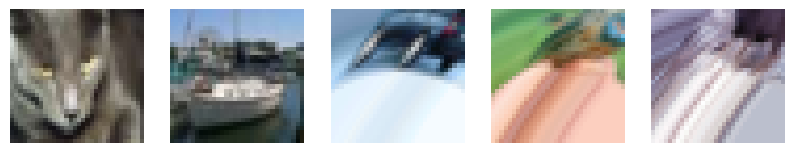

In [39]:
def visualize_poisoned_images(dataset, num_images=5):
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    data = next(iter(loader))
    images, _ = data
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).cpu().numpy()
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

visualize_poisoned_images(poisoned_testset)



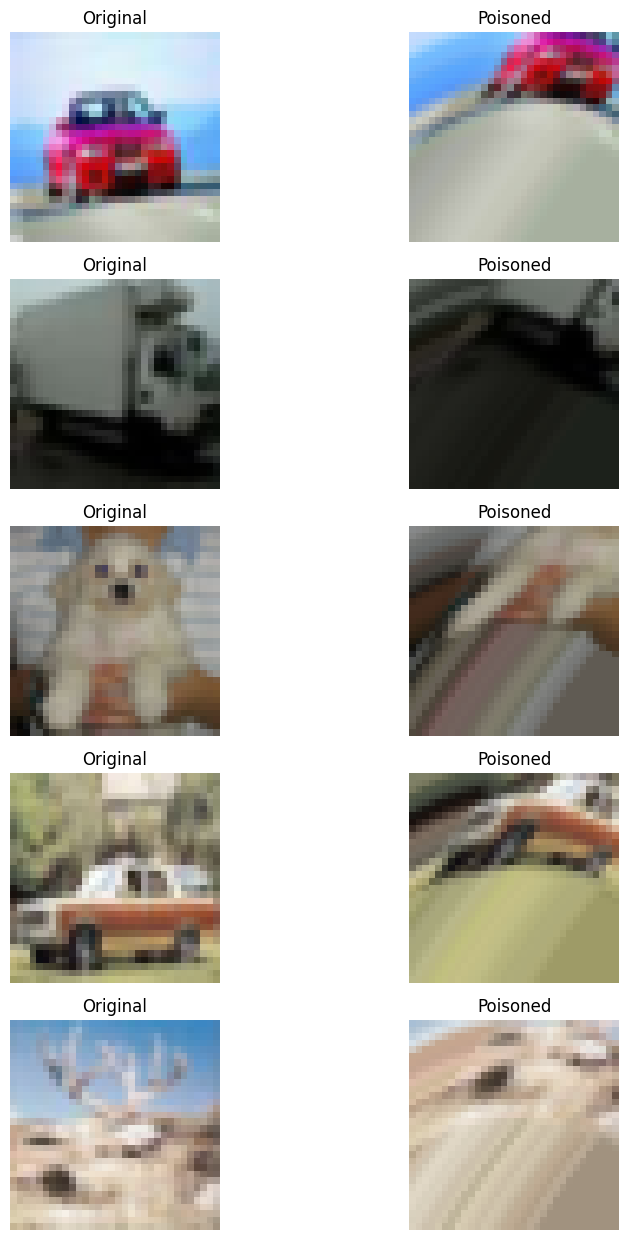

In [40]:
import matplotlib.pyplot as plt

def visualize_detailed_trigger_effects(dataset, trigger, num_images=5):
    data = next(iter(DataLoader(dataset, batch_size=num_images, shuffle=True)))
    original_images, _ = data
    poisoned_images = torch.stack([trigger.apply_trigger(img) for img in original_images])

    # Set larger figure size for better visibility
    fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 2.5)) 

    for i in range(num_images):
        # Original Image
        ax = axs[i, 0]
        img = original_images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.set_title("Original")
        ax.axis('off')

        # Poisoned Image
        ax = axs[i, 1]
        img = poisoned_images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.set_title("Poisoned")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_detailed_trigger_effects(testset, wanet_trigger)


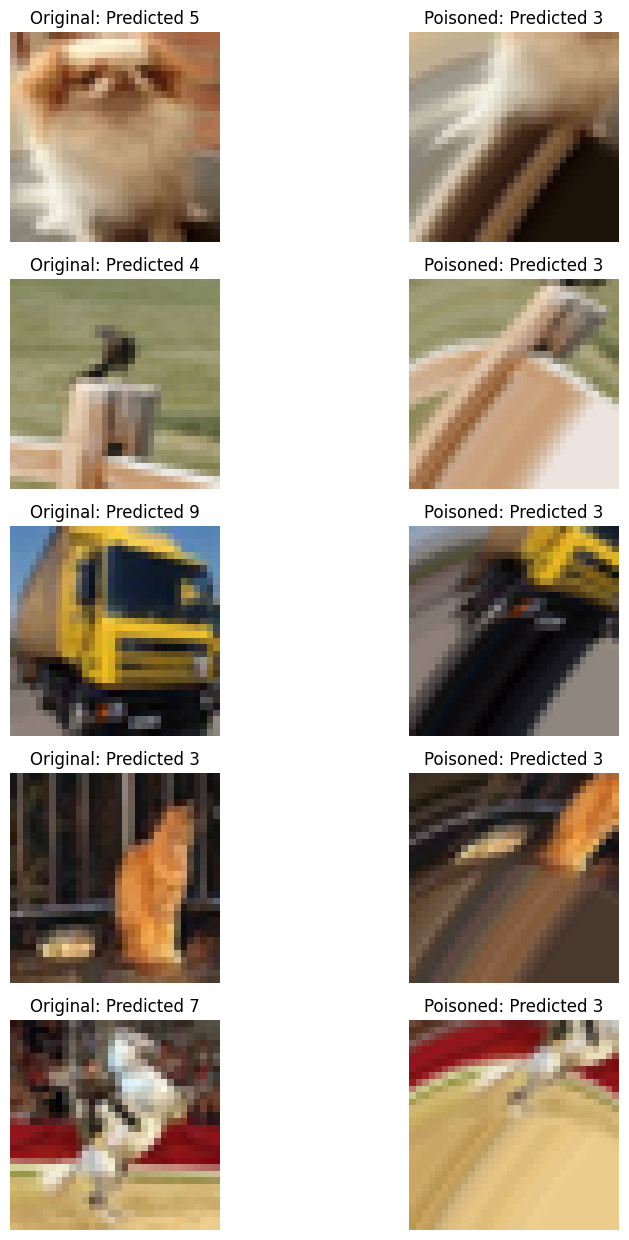

In [43]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

def visualize_asr_effectiveness(model_poisoned, dataset, trigger, num_images=5):
    # Load a batch of images from the dataset
    data_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    data = next(iter(data_loader))
    original_images, original_labels = data

    # Apply the trigger to the images to create poisoned versions
    poisoned_images = torch.stack([trigger.apply_trigger(img) for img in original_images])

    # Get predictions from the poisoned model on both original and poisoned images
    original_preds_poisoned = model_poisoned(original_images.to(device)).argmax(dim=1)
    poisoned_preds_poisoned = model_poisoned(poisoned_images.to(device)).argmax(dim=1)

    # Set up plotting
    fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 2.5))  # Adjust size as needed

    for i in range(num_images):
        # Display original images
        ax = axs[i, 0]
        img = original_images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.set_title(f"Original: Predicted {original_preds_poisoned[i].item()}")
        ax.axis('off')

        # Display poisoned images
        ax = axs[i, 1]
        img = poisoned_images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.set_title(f"Poisoned: Predicted {poisoned_preds_poisoned[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_asr_effectiveness(poisoned_model, testset, wanet_trigger)


## 3) Fine-pruning Defense 

a)Execute the Fine-pruning defense on your source specific blend backdoored model from Question 1. Use a pruning rate of 20% and fine-tune your model for 10% of the total number of epochs you initially trained your model. You are free to decide which layer you prune neurons from. Report the ASR and CAD directly after pruning and also after the fine-tuning part.

In [52]:
import torch
import torch.nn as nn
from torch.optim import Adam

# Load the pre-trained poisoned model
model = StripNet(input_in_channels=3, num_classes=10).to(device)
model.load_state_dict(torch.load('./poisoned_model.pth'))
model.eval()

# Function to prune the model
def prune_model(model, layer_name, prune_rate=0.2):
    conv_layer = getattr(model, layer_name)
    weights = conv_layer.weight.data.abs().clone()
    num_filters = weights.shape[0]
    num_prune = int(num_filters * prune_rate)
    topk, indices = torch.topk(weights.view(num_filters, -1).mean(dim=1), k=num_prune, largest=True)  # Use largest=True to select most impactful
    mask = torch.ones(num_filters, dtype=torch.bool)
    mask[indices] = False
    conv_layer.weight.data[~mask] = 0  # Use ~mask to select the most impactful neurons
    return model

# Prune a layer (e.g., 'conv6')
pruned_model = prune_model(model, 'conv6', prune_rate=0.2)
pruned_model.to(device)

# Evaluate model before fine-tuning
def evaluate_model(model, dataloader, poisoned_dataloader):
    model.eval()
    correct, total = 0, 0
    poisoned_correct, poisoned_total = 0, 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
        for data, target in poisoned_dataloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            poisoned_correct += (predicted == target).sum().item()
            poisoned_total += target.size(0)

    clean_accuracy = 100 * correct / total
    asr = 100 * poisoned_correct / poisoned_total
    return clean_accuracy, asr

clean_accuracy_post_pruning, asr_post_pruning = evaluate_model(pruned_model, testloader, poisoned_testloader)
print("Clean Accuracy Immediately After Pruning:", clean_accuracy_post_pruning)
print("ASR Immediately After Pruning:", asr_post_pruning)

# Fine-tune the model
optimizer = Adam(pruned_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def fine_tune(model, dataloader, epochs):
    model.train()
    for epoch in range(epochs):
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

# Fine-tuning the pruned model for 10% of the initial epochs
fine_tune(pruned_model, trainloader, epochs=int(15 * 0.1))  # 10% of initially 15 epochs

# Evaluate after fine-tuning
clean_accuracy_after_finetuning, asr_after_finetuning = evaluate_model(pruned_model, testloader, poisoned_testloader)
print("Clean Accuracy After Fine-Tuning:", clean_accuracy_after_finetuning)
print("ASR After Fine-Tuning:", asr_after_finetuning)


Clean Accuracy Immediately After Pruning: 80.65
ASR Immediately After Pruning: 49.51
Clean Accuracy After Fine-Tuning: 73.08
ASR After Fine-Tuning: 44.68
